# Project 02 - No.8
## 網路股票討論度與波動度關係之探討 - 以PTT股票版為例

In [1]:
import requests
import time
from datetime import datetime
from bs4 import BeautifulSoup
import os
import re
import urllib.request
import json
import jieba
import jieba.analyse
import pandas as pd
from pandas.core.frame import DataFrame

In [2]:
PTT_URL = 'https://www.ptt.cc'

In [3]:
def get_web_page(url):
    time.sleep(0.5)  # 每次爬取前暫停 0.5 秒以免被 PTT 網站判定為大量惡意爬取
    resp = requests.get(url=url)
    if resp.status_code != 200:
        print('Invalid url:', resp.url)
        return None
    else:
        return resp.text

In [4]:
def get_articles(dom, date):
    soup = BeautifulSoup(dom, 'html.parser')

    # 取得上一頁的連結
    paging_div = soup.find('div', 'btn-group btn-group-paging')
    prev_url = paging_div.find_all('a')[1]['href']

    articles = []  # 儲存取得的文章資料
    divs = soup.find_all('div', 'r-ent')
    for d in divs:
        if d.find('div', 'date').string.strip() == date:  # 發文日期正確
            # 取得推文數
            push_count = 0
            if d.find('div', 'nrec').string:
                try:
                    push_count = int(d.find('div', 'nrec').string)  # 轉換字串為數字
                except ValueError:  # 若轉換失敗，不做任何事，push_count 保持為 0
                    pass

            # 取得文章連結及標題
            if d.find('a'):  # 有超連結，表示文章存在，未被刪除
                href = d.find('a')['href']
                title = d.find('a').string
                articles.append({
                    'title': title,
                    'date': date,
                    'push_count': push_count
                })
    return articles, prev_url

In [5]:
def parse(dom):
    soup = BeautifulSoup(dom, 'html.parser')
    links = soup.find(id='main-content').find_all('a')
    img_urls = []
    for link in links:
        if re.match(r'^https?://(i.)?(m.)?imgur.com', link['href']):
            img_urls.append(link['href'])
    return img_urls


In [6]:
def get_datelist(beginDate, endDate):
    # beginDate, endDate是形如‘20160601’的字符串或datetime格式
    date_list=[datetime.strftime(x,'%m/%d') for x in list(pd.date_range(start=beginDate, end=endDate))]
    return date_list

In [7]:
if __name__ == '__main__':
    current_page = get_web_page(PTT_URL + '/bbs/Stock/index.html')
    if current_page:
        articles = []  #全部的文章
        
    dates = (get_datelist('20171207','20180109')) #endDate需為當天
    for c in dates[::-1]:#倒序
        date = time.strftime(c).lstrip('0') # 去掉開頭的 '0' 以符合 PTT 網站日期格式
        current_articles, prev_url = get_articles(current_page, date)  # 目前頁面的文章
        while current_articles:  # 若目前頁面有文章則加入 articles，並回到上一頁繼續尋找是否有符合日期的文章
            articles += current_articles
            current_page = get_web_page(PTT_URL + prev_url)
            current_articles, prev_url = get_articles(current_page, date)

In [8]:
articles=DataFrame(articles)
articles

,date,push_count,title
0,1/09,1,[新聞] 中信金去年稅後盈餘成長33% 台壽獲利首破
1,1/09,4,[請益] 凌巨
2,1/09,7,[新聞] 正崴 2017年12月合併營收92.32億元
3,1/09,0,[閒聊] 2018/01/09 盤後閒聊
4,1/09,12,[請益] 國際油價拼命噴 航運類股
5,1/09,5,Re: [標的] 橘子6180 多多
6,1/09,0,Re: [標的] 橘子6180 多多
7,1/09,10,Re: [標的] 橘子6180 多多
8,1/09,29,[其他] 107年01月09日信用交易統計
9,1/09,3,[請益] 元大or凱基借券?


In [9]:
from pandas import ExcelWriter
 
writer = pd.ExcelWriter('articles.xlsx')
articles.to_excel(writer,'Sheet1')
writer.save()

In [10]:
def get_keywords(content):
    keywords=jieba.analyse.extract_tags(str(content),topK=50) 
    return "/".join(keywords)

In [11]:
keywords_sort=articles.groupby('date').apply(get_keywords)
keywords_sort

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.cache
Loading model cost 0.934 seconds.
Prefix dict has been built succesfully.


date
1/01     01/請益/追高殺/低長/期能/Re/新聞/13/date/push/count/title...
1/02     02/新聞/Re/請益/01/2017/股匯/雙漲/台幣/開盤/大升/9.3/心得/11/4...
1/03     03/新聞/Re/請益/13/28/閒聊/2018/01/14/23/榮海/日電貿/11/資...
1/04     04/新聞/Re/13/美股/進入/終章/專家/標普融/50%/01/2018/請益/怎麼/...
1/05     05/新聞/Re/請益/閒聊/2018/01/心得/20/32/穩懋/張表打/臉大老/企業/...
1/06     06/新聞/13/Re/請益/心得/告白/違反板規/本魯自/師的/投資/水桶/財經/強勢/1...
1/07     07/新聞/Re/25000/點還/low/川普自/曝美股/驚人數/告白/本魯自/師的/投資...
1/08     08/Re/新聞/請益/12/畢業/附對/帳單/01/心得/付費/107/營收/16/ptt...
1/09     09/Re/新聞/請益/12/6180/貸款/歐印/橘子/2018/01/多多/三百/營收/...
12/07    12/07/Re/新聞/請益/11/心得/投資/10/一樣/輕人/營收/股價/鴻海/17/1...
12/08    12/08/Re/請益/新聞/11/群創/營收/.../16/比特/17/指期/EPS/南亞...
12/09    12/09/新聞/11/Re/13/台股/營收/請益/比特/晶電/15/家金控/賺贏/幣破/...
12/10    12/10/Re/請益/新聞/全職/問題/11/出現/心得/橘子/違反板規/一週/營收/13...
12/11    11/12/新聞/Re/請益/橘子/登陸華爾街/10/比特/作多/交易/15/決在/兩岸/外...
12/12    12/新聞/Re/請益/11/閒聊/心得/全職/出現/問題/34/指期/外資/倉淨口數/vs...
12/13    12/13/Re/請益/新聞/閒聊/36/2809/銀行/績效/其他/橘子/天堂/裝置/49...
12/14    12/14/新聞/Re/橘子/6180/2017/心得/蘋果/29/投資/24/閒聊

In [12]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
keywords_sort.str.split('/',expand=True)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1/01,01,請益,追高殺,低長,期能,Re,新聞,13,date,push,count,title,393,85,394,51,陸徵環,保稅,負擔,變重,395,嚴凱泰,無所適,396,12,3450,聯鈞,397,8039,台虹,398,28,399,飛利浦,LED,101,整棟,外牆,400,4401,東隆興,401,6223,旺矽,402,CHL,403,17,404,46
1/02,02,新聞,Re,請益,01,2017,股匯,雙漲,台幣,開盤,大升,9.3,心得,11,41,閒聊,107,未來,18,大手筆,國際,電玩展,108,攤位,宏達電,VR,賞析,2018,16,10,台股,八萬元,辦法,創意,3443,籌碼面,股價,包下,美元,橘子,翻倍,一直,其他,新年好,要角,哭哭,date,push,count,title
1/03,03,新聞,Re,請益,13,28,閒聊,2018,01,14,23,榮海,日電貿,11,資金,股利,好奇,玩死,其他,短空,date,push,count,title,297,2233,宇隆,103,進獲利,108,298,59,盤子,怒花,200,紫變,299,22,盤後閒,300,37,107,日三大,買賣,金額,統計表,301,養大台灣,發越,302
1/04,04,新聞,Re,13,美股,進入,終章,專家,標普融,50%,01,2018,請益,怎麼,14,獲利,29,穩懋,閒聊,18,泡沫,市場,27,20,電動,機車,電池,規格,Gogoro,24,大盤,32,107,19,23,21,請問,停利點,3105,3D,其他,反向,法人,大大,date,push,count,title,245,2367
1/05,05,新聞,Re,請益,閒聊,2018,01,心得,20,32,穩懋,張表打,臉大老,企業,4915,致伸,大盤,10,ETF,國產車,19,盤子,269,萬終,紫變,美股,進入,終章,專家,標普融,50%,天堂,瑞波,泡沫,看好,告白,date,push,count,title,208,營業員會,別家,單狀況,209,有關,外資,00632R,大賣,張數
1/06,06,新聞,13,Re,請益,心得,告白,違反板規,本魯自,師的,投資,水桶,財經,強勢,16,10,一週,台灣,分析,股票,公告,破百,可判,date,push,count,title,186,觀測,著大股,東進,出準,沒錯,187,進口車,執行長,嚴凱泰,188,15,6462,神盾,189,42,檔大戶,領攻,11,000,190,49,宏達電
1/07,07,新聞,Re,25000,點還,low,川普自,曝美股,驚人數,告白,本魯自,師的,投資,公股,心得,本週,慶富案,提呆,銀上,獲利大減,股票,分析,味全,斗六,date,push,count,title,159,160,42,不幹,元大,大眾,銀爆,760,人離職,有分,161,大電信,4G,網速表現,最優,OpenSi,162,55,選股,結果,163,18
1/08,08,Re,新聞,請益,12,畢業,附對,帳單,01,心得,付費,107,營收,16,ptt,文對,作勝率,11,20,...,教有,理財寶內,軟體,版友,2018,閒聊,新高,13,..,3227,原相,99,106,浩鼎,億元,17,外資,日三大,買賣,金額,統計表,18,28,投資,季節,其他,去年,旺季,法人,概念股
1/09,09,Re,新聞,請益,12,6180,貸款,歐印,橘子,2018,01,多多,三百,營收,億元,閒聊,10,心得,11,25,15,怎麼,...,直接,去年,成長,盤後閒,29,107,14,16,17,題材,客觀,20,26,27,台幣,豐金,266,精材,3374,推薦,穩健,92,致富,其他,消息面,股票,味全


In [13]:
import matplotlib.pyplot as plt
import datetime
import plotly.plotly as py
from matplotlib.dates import date2num
from pandas.core.frame import DataFrame
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
import numpy as np

In [15]:
df = pd.read_excel("C:\\Users\\user\\Desktop\\final project\\result.xlsx")
df

,Return(today),Return(tomorrow),close(yesterday),close(today),close(tomorrow),STD(monthly),討論度,當日波動度,隔日波動度
1909,-1.2850,-8.4024,42.80,42.25,38.70,2.539983,22,1.2850,8.4024
3008,-9.8309,0.8206,4730.00,4265.00,4300.00,3.532723,162,9.8309,0.8206
6180,-9.7059,9.6634,102.00,92.10,101.00,5.647754,280,9.7059,9.6634
3481,-1.9920,3.2520,12.55,12.30,12.70,1.253438,49,1.9920,3.2520
1710,-1.9802,-10.0000,101.00,99.00,89.10,1.812063,278,1.9802,10.0000
6180,-10.0000,0.6734,99.00,89.10,89.70,5.647754,277,10.0000,0.6734
6180,0.6734,-9.9220,89.10,89.70,80.80,5.647754,135,0.6734,9.9220
6180,-9.9220,-3.2178,89.70,80.80,78.20,5.647754,383,9.9220,3.2178
6180,-3.2178,-0.8951,80.80,78.20,77.50,5.647754,45,3.2178,0.8951
6180,-0.8951,5.8065,78.20,77.50,82.00,5.647754,61,0.8951,5.8065


In [16]:
df = DataFrame(df)

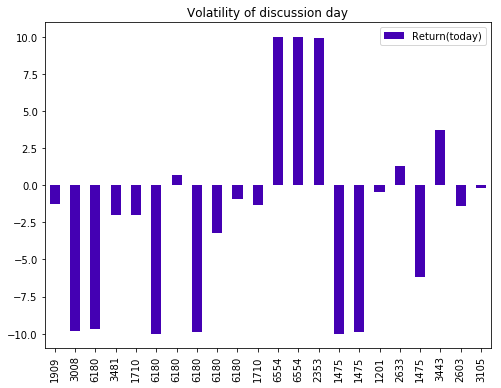

In [17]:
a=df.plot.bar(y= ['Return(today)'], title='Volatility of discussion day',figsize=(8,6),color='#4400B3')
plt.show()

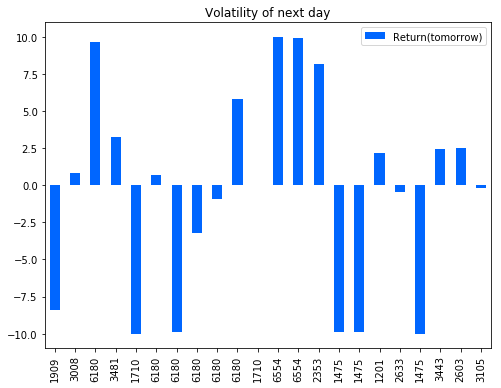

In [18]:
b=df.plot.bar(y= ['Return(tomorrow)'], title='Volatility of next day',figsize=(8,6),color='#0066FF')
plt.show()

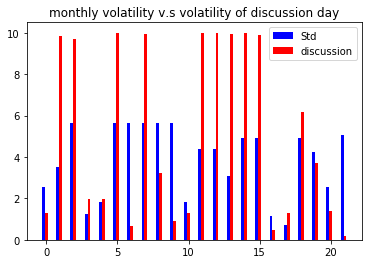

In [19]:
x = np.arange(22)

y = (2.5400,3.5327,5.6478,1.2534,1.8121,5.6478,5.6478,5.6478,5.6478,5.6478,
     1.8121,4.3917,4.3917,3.0728,4.9167,4.9167,1.1403,0.7292,4.9167,4.2311,
     2.5649,5.0807)

z = (1.285,9.8309,9.7059,1.992,1.9802,10,0.6734,9.922,3.2178,0.8951,
     1.3029,9.9744,10,9.9515,10,9.8765,0.4796,1.2876,6.1914,3.7255,
     1.3928,0.1645)

ax = plt.subplot(111)

a=ax.bar(x-0.2, y,width=0.2,color='b',align='center')
b=ax.bar(x, z,width=0.2,color='r',align='center')
ax.legend((a, b), ('Std', 'discussion'))
ax.set_title('monthly volatility v.s volatility of discussion day')



plt.show()

In [20]:
# H0:月波動>=當日波動 , H1:月波動<當日波動 , true表示顯著 , false表示不顯著
x=21*df['STD(monthly)']*df['STD(monthly)']
y=df['當日波動度']*df['當日波動度']
r=x/y
r<11.5913

1909    False
3008     True
6180     True
3481     True
1710    False
6180     True
6180    False
6180     True
6180    False
6180    False
1710    False
6554     True
6554     True
2353     True
1475     True
1475     True
1201    False
2633     True
1475    False
3443    False
2603    False
3105    False
dtype: bool

In [21]:
# H0:月波動>=隔日波動 , H1:月波動<隔日波動 , true表示顯著 , false表示不顯著
x=21*df['STD(monthly)']*df['STD(monthly)']
y=df['隔日波動度']*df['隔日波動度']
r=x/y
r<11.5913

1909     True
3008    False
6180     True
3481     True
1710     True
6180    False
6180     True
6180    False
6180    False
6180    False
1710    False
6554     True
6554     True
2353     True
1475     True
1475     True
1201     True
2633    False
1475     True
3443    False
2603    False
3105    False
dtype: bool

In [22]:
discussion = np.array([22,162,280,49,278,277,135,383,45,61,9,169,63,66,93,121,15,64,60,39,15,24])

volatility = np.array([1.285,9.8309,9.7059,1.992,1.9802,10,0.6734,9.922,3.2178,0.8951,1.3029,9.9744,
                           10,9.9515,10,9.8765,0.4796,1.2876,6.1914,3.7255,1.3928,0.1645])

lm = LinearRegression()
lm.fit(np.reshape(discussion, (len(discussion), 1)), np.reshape(volatility, (len(volatility), 1)))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
print(lm.intercept_ )
print(lm.coef_)

[ 2.81196387]
[[ 0.02139333]]


In [24]:
# 轉換維度
discussion = np.reshape(discussion, (len(discussion), 1))
volatility = np.reshape(volatility, (len(volatility), 1))

lm = LinearRegression()
lm.fit(discussion, volatility)

# 模型績效
mse = np.mean((lm.predict(discussion) - volatility) ** 2)
r_squared = lm.score(discussion, volatility)

# 印出模型績效
print(mse)
print(r_squared)
print(f_regression(discussion, volatility)[1])

12.1764835747
0.285864608167
[ 0.01035852]


C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



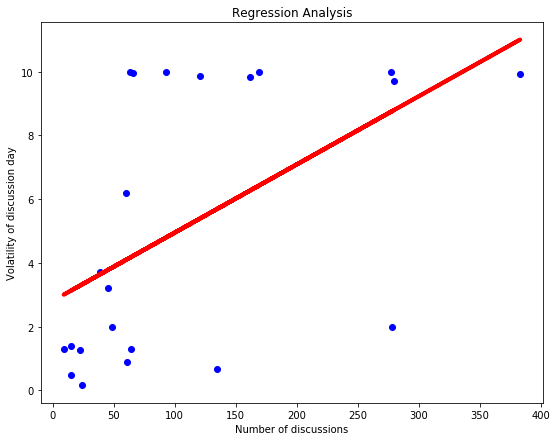

In [25]:
plt.figure(figsize=(9,7))
plt.scatter(discussion, volatility, color='blue')
plt.plot(discussion, lm.predict(np.reshape(discussion, (len(discussion), 1))), color='red', linewidth=4)
plt.title("Regression Analysis")
plt.xlabel("Number of discussions")
plt.ylabel("Volatility of discussion day")
plt.show()

In [26]:
discussion2 = np.array([22,162,280,49,278,277,135,383,45,61,9,169,63,66,93,121,15,64,60,39,15,24])

volatility2 = np.array([8.4024,0.8206,9.6634,3.252,10,0.6734,9.922,3.2178,0.8951,5.8065,0,10,9.9366,8.1678,
                       9.8765,9.8935,2.1687,0.4237,10,2.4575,2.5424,0.1647])

lm = LinearRegression()
lm.fit(np.reshape(discussion2, (len(discussion2), 1)), np.reshape(volatility2, (len(volatility2), 1)))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [27]:
print(lm.intercept_ )
print(lm.coef_)

[ 4.5190436]
[[ 0.00776364]]


In [28]:
# 轉換維度
discussion2 = np.reshape(discussion2, (len(discussion2), 1))
volatility2 = np.reshape(volatility2, (len(volatility2), 1))

lm = LinearRegression()
lm.fit(discussion2, volatility2)

# 模型績效
mse = np.mean((lm.predict(discussion2) - volatility2) ** 2)
r_squared = lm.score(discussion2, volatility2)

# 印出模型績效
print(mse)
print(r_squared)
print(f_regression(discussion2, volatility2)[1])

15.7818960527
0.0390842343332
[ 0.37782782]


C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



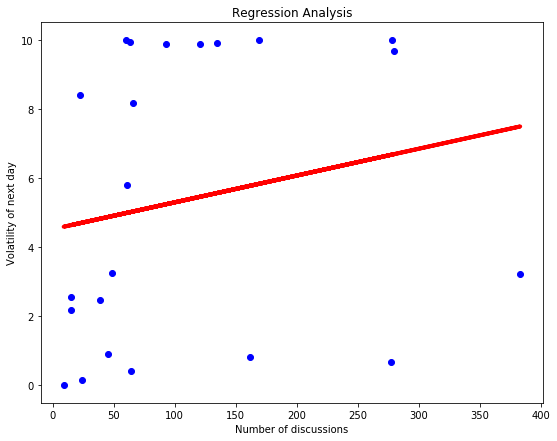

In [29]:
plt.figure(figsize=(9,7))
plt.scatter(discussion2, volatility2, color='blue')
plt.plot(discussion2, lm.predict(np.reshape(discussion2, (len(discussion2), 1))), color='red', linewidth=4)
plt.title("Regression Analysis")
plt.xlabel("Number of discussions")
plt.ylabel("Volatility of next day")
plt.show()